# Point source sensitivity
## Introduction

This notebook explains how to estimate the SST-1M sensitivity for a point-like IRF at a fixed zenith angle and fixed offset using the full containment IRFs. The significance is computed for a 1D analysis (On-OFF regions) and the LiMa formula.

We use here an approximate approach with an energy dependent integration radius to take into account the variation of the PSF. We will first determine the 1D IRFs including a containment correction. 

We will be using the following Gammapy class:

* `~gammapy.estimators.SensitivityEstimator`

## Setup
As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import os

In [2]:
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, EarthLocation

from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.data import Observation, observatory_locations
from gammapy.estimators import SensitivityEstimator
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.maps import MapAxis, RegionGeom
from pathlib import Path
import pandas as pd

In [5]:
!ls ../IRFs/sensitivity

flux_sensitivity_stereo.h5


In [58]:
# Setting up directories
p = Path('..').resolve()
sens_file = p / 'IRFs/sensitivity/flux_sensitivity_stereo.h5'
with pd.HDFStore(sens_file) as f:
    SST1M_Sensitivity = f.sensitivity["flux_sensitivity"]
    SST1M_Sensitivity_err_m = f.sensitivity["flux_sensitivity_err_minus"]
    SST1M_Sensitivity_err_p = f.sensitivity["flux_sensitivity_err_plus"]
    SST1M_Energy = f.sensitivity["energy"]
    SST1M_Energy_Lo = f.sensitivity["energy_min"]
    SST1M_Energy_Hi = f.sensitivity["energy_max"]
    mean_sens = np.mean(f.sensitivity["energy"])

In [59]:
print('i\tENERGY\tENERGY_LO\tENERGY_HI\tFluxSensitivity\tFluxSens_err_m\tFluxSens_err_p')
for i,(en,en_lo,en_hi,sens,sens_lo,sens_hi) in enumerate(zip(SST1M_Energy,SST1M_Energy_Lo,SST1M_Energy_Hi,SST1M_Sensitivity,SST1M_Sensitivity_err_m,SST1M_Sensitivity_err_p)):
    print(f'{i}\t{en:.2f}\t{en_lo:.2f}\t{en_hi:.2f}\t{sens:.2e}\t{sens_lo:.2e}\t{sens_hi:.2e}')

i	ENERGY	ENERGY_LO	ENERGY_HI	FluxSensitivity	FluxSens_err_m	FluxSens_err_p
0	0.13	0.10	0.16	nan	nan	nan
1	0.20	0.16	0.25	nan	nan	nan
2	0.32	0.25	0.40	nan	nan	nan
3	0.50	0.40	0.63	nan	nan	nan
4	0.79	0.63	1.00	1.37e-10	1.66e-11	2.00e-11
5	1.26	1.00	1.58	1.20e-11	4.54e-13	4.70e-13
6	2.00	1.58	2.51	4.03e-12	1.08e-13	1.09e-13
7	3.16	2.51	3.98	2.59e-12	7.07e-14	7.14e-14
8	5.01	3.98	6.31	2.06e-12	5.89e-14	5.94e-14
9	7.94	6.31	10.00	1.98e-12	5.61e-14	5.65e-14
10	12.59	10.00	15.85	1.82e-12	5.30e-14	5.34e-14
11	19.95	15.85	25.12	1.86e-12	5.58e-14	5.64e-14
12	31.62	25.12	39.81	2.00e-12	6.58e-14	6.66e-14
13	50.12	39.81	63.10	2.24e-12	8.37e-14	8.48e-14
14	79.43	63.10	100.00	3.45e-12	7.63e-14	7.98e-14
15	125.89	100.00	158.49	5.89e-12	1.68e-13	1.78e-13
16	199.53	158.49	251.19	nan	nan	nan
17	316.23	251.19	398.11	nan	nan	nan
18	501.19	398.11	630.96	nan	nan	nan
19	794.33	630.96	1000.00	nan	nan	nan


## Define analysis region and energy binning

Here we assume a source at 1.4 degree from pointing position. We perform a simple energy independent extraction for now with a radius of 0.1 degree.

In [104]:
# I use the same energy binning used in the Flux Sensitivity file
energy_axis = MapAxis.from_energy_bounds("0.63 TeV", "158.5 TeV", nbin=12)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.2 TeV", "800 TeV", nbin=100, name="energy_true"
)

offset = 1.4 # deg
geom = RegionGeom.create(f"icrs;circle(0, {offset}, 0.1)", axes=[energy_axis])

empty_dataset = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

## Load IRFs and prepare dataset

We extract the 1D IRFs from the full 3D IRFs provided by CTA. 

In [61]:
IRF20_file = p / "IRFs/data/sst1m_stereo/0_4/bcf/ze20_az180_nsb100_gc0.75/SST1M_stereo_Zen20deg_gcut0.75_irfs.fits"
IRF30_file = p / "IRFs/data/sst1m_stereo/0_4/bcf/ze30_az180_nsb100_gc0.75/SST1M_stereo_Zen30deg_gcut0.75_irfs.fits"
IRF40_file = p / "IRFs/data/sst1m_stereo/0_4/bcf/ze40_az180_nsb100_gc0.75/SST1M_stereo_Zen40deg_gcut0.75_irfs.fits"

hdul = fits.open(IRF20_file)
hdul.info()
print(hdul['ENERGY DISPERSION'].data.columns)
Elo = hdul['ENERGY DISPERSION'].data['ENERG_LO']
Ehi = hdul['ENERGY DISPERSION'].data['ENERG_HI']

Filename: /Users/bowe46/WORK/SST-1M/ALL_repo/Observation_plan_maker/IRFs/data/sst1m_stereo/0_4/bcf/ze20_az180_nsb100_gc0.75/SST1M_stereo_Zen20deg_gcut0.75_irfs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EFFECTIVE AREA    1 BinTableHDU     38   1R x 5C   [20D, 20D, 8D, 8D, 160D]   
  2  POINT SPREAD FUNCTION    1 BinTableHDU     47   1R x 7C   [20D, 20D, 8D, 8D, 16D, 16D, 2560D]   
  3  ENERGY DISPERSION    1 BinTableHDU     44   1R x 7C   [50D, 50D, 50D, 50D, 8D, 8D, 20000D]   
  4  BACKGROUND    1 BinTableHDU     39   1R x 5C   [20D, 20D, 16D, 16D, 320D]   
ColDefs(
    name = 'ENERG_LO'; format = '50D'; unit = 'TeV'; dim = '(50)'
    name = 'ENERG_HI'; format = '50D'; unit = 'TeV'; dim = '(50)'
    name = 'MIGRA_LO'; format = '50D'; dim = '(50)'
    name = 'MIGRA_HI'; format = '50D'; dim = '(50)'
    name = 'THETA_LO'; format = '8D'; unit = 'deg'; dim = '(8)'
    name = 'THETA_HI'; format = '8D'; unit = '

In [62]:
print(f'{hdul['ENERGY DISPERSION'].data['ENERG_LO'][:,0]} TeV')
print(f'{hdul['ENERGY DISPERSION'].data['ENERG_HI'][:,-1]} TeV')
print(f'{hdul['ENERGY DISPERSION'].data['MIGRA_LO'][:,0]} TeV')
print(f'{hdul['ENERGY DISPERSION'].data['MIGRA_HI'][:,-1]} TeV')

[0.2] TeV
[300.] TeV
[0.1] TeV
[4.] TeV


In [63]:
location = observatory_locations["cta_south"]
print(location)
location.lon
observatory_locations

(1953830.40071076, -5461745.48215685, -2648150.15076259) m


{'cta_south': <EarthLocation (1953830.40071076, -5461745.48215685, -2648150.15076259) m>,
 'cta_north': <EarthLocation (5326744.14419991, -1719670.68542112, 3051852.61422433) m>,
 'hawc': <EarthLocation (-768048.67304, -5987726.52318414, 2064335.19214093) m>,
 'hegra': <EarthLocation (5324402.17229679, 2922477.69543812, 1947565.59400008) m>,
 'hess': <EarthLocation (5622482.08529426, 1665478.78910994, -2505121.94111838) m>,
 'magic': <EarthLocation (5326859.67992517, -1719502.15154854, 3051856.77751797) m>,
 'milagro': <EarthLocation (-1485314.58540702, -4958277.64987376, 3718745.87710186) m>,
 'veritas': <EarthLocation (-1943186.26739753, -5074834.80871364, 3330487.41415047) m>,
 'whipple': <EarthLocation (-1936925.93988308, -5078068.85469291, 3331761.38143003) m>,
 'astri': <EarthLocation (5390438.56093766, -1597317.33800122, 3006942.84196311) m>,
 'fact': <EarthLocation (5326841.28720322, -1719610.78188096, 3051827.86831929) m>}

In [64]:
loc_ondrejov = p / 'config' / 'location_ondrejov.txt'
loc_ondrejov = os.fspath(loc_ondrejov.resolve())

with open(loc_ondrejov, 'r') as f:
    ondrejov = f.read()
    ondrejov = ondrejov.split()
    print(ondrejov)
location = EarthLocation.from_geodetic(*ondrejov)
print(location.geodetic)
print(location.info)
print(location.info.meta)

['49.912173', '14.782195', '510']
GeodeticLocation(lon=<Longitude 49.912173 deg>, lat=<Latitude 14.782195 deg>, height=<Quantity 510. m>)
dtype = (float64, float64, float64)
unit = m
class = EarthLocation
n_bad = 0

None


In [65]:
irfs = load_irf_dict_from_file(IRF20_file)
pointing = SkyCoord("0 deg", "0 deg")
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime="50 h", location=location
)

/Users/bowe46/miniforge3/envs/digicamscheduling/lib/python3.12/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [66]:
spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"]
)
dataset = spectrum_maker.run(empty_dataset, obs)

Now we correct for the energy dependent region size:

In [67]:
containment = 0.68

# correct exposure
dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=offset * u.deg, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
dataset.background *= factor.value.reshape((-1, 1, 1))

And finally define a `SpectrumDatasetOnOff` with an alpha of `0.2`. The off counts are created from the background model:

In [68]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

## Compute sensitivity

We impose a minimal number of expected signal counts of 5 per bin and a minimal significance of 3 per bin. We assume an alpha of 0.2 (ratio between ON and OFF area).
We then run the sensitivity estimator.

In [103]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, n_sigma=3, bkg_syst_fraction=0.20
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

## Results

The results are given as an Astropy table. A column criterion allows to distinguish bins where the significance is limited by the signal statistical significance from bins where the sensitivity is limited by the number of signal counts.
This is visible in the plot below.

In [100]:
# Show the results table
sensitivity_table

energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.793175,0.793175,0.63,0.998615,6.66085e-11,5,0.195085,gamma
1.25726,1.25726,0.998615,1.58291,5.59753e-12,18.7406,25.7183,significance
1.99289,1.99289,1.58291,2.50907,3.02912e-12,24.4614,46.3842,significance
3.15894,3.15894,2.50907,3.97713,2.43483e-12,21.6553,35.4904,significance
5.00724,5.00724,3.97713,6.30416,1.9939e-12,17.2586,21.3522,significance
7.937,7.937,6.30416,9.99275,1.84914e-12,14.3086,13.8711,significance
12.581,12.581,9.99275,15.8395,1.78436e-12,11.8637,8.8902,significance
19.9421,19.9421,15.8395,25.1073,1.72946e-12,9.53809,5.17697,significance


In [101]:
# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

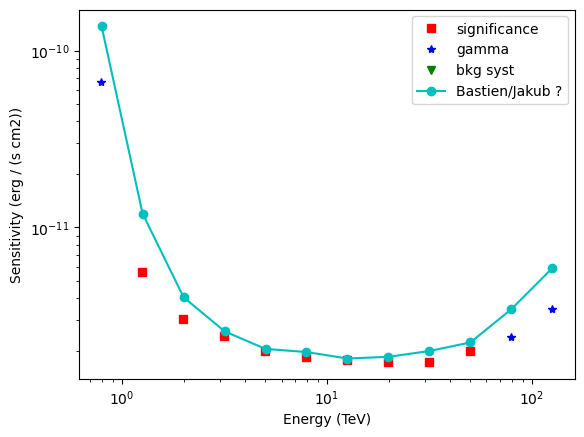

In [102]:
# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"
plt.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
plt.plot(
    t["energy"][is_g], t["e2dnde"][is_g], "*", color="blue", label="gamma"
)
is_bkg_syst = t["criterion"] == "bkg"
plt.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v",
    color="green",
    label="bkg syst",
)

plt.loglog()
plt.xlabel(f"Energy ({t['energy'].unit})")
plt.ylabel(f"Sensitivity ({t['e2dnde'].unit})")

plt.plot(SST1M_Energy,SST1M_Sensitivity,'oc-',label='Bastien/Jakub ?')
plt.legend()

We add some control plots showing the expected number of background counts per bin and the ON region size cut (here the 68% containment radius of the PSF).

(0.01, 0.5)

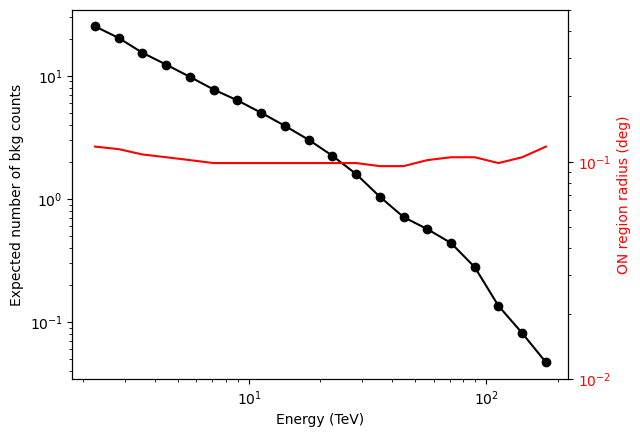

In [34]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(
    t["energy"], t["background"], "o-", color="black", label="blackground"
)

ax1.loglog()
ax1.set_xlabel(f"Energy ({t['energy'].unit})")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius ({on_radii.unit})", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)